In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.optimize import dual_annealing
from scipy.stats import linregress
import scipy.optimize
from scipy.optimize import curve_fit

# Get the current notebook's directory
notebook_dir = os.getcwd()

# Append the path to 'intermittentLevy' directory
sys.path.append(os.path.join(notebook_dir, 'intermittentLevy'))
import importlib
import functions
importlib.reload(functions)
# Import functions from 'functions.py'
from functions import moment4, to_optimize_mom4, mom22_4_diff, to_optimize_mom22_4_diff, intermittent2, levy_flight_2D_2, setup_kde,mom2_model, mom4_model, form_groups, adjusted_r_square, load_parameters, setup_kde,powerl_fit, perform_iterations,perform_estimation


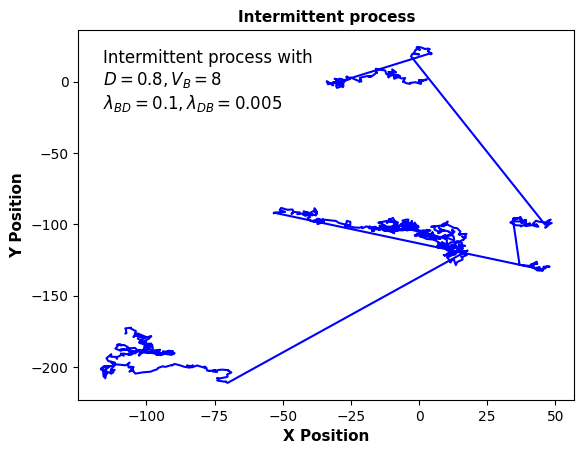

In [2]:
# Generate an intermittent trajectory
x, y = intermittent2(nt=1000, dt=1, mean_bal_sac=8, diffusion=0.8, rate21=0.1, rate12=0.005)
# Plot intermittent trajectory
plt.plot(x, y, color='blue')
plt.xlabel('X Position',fontsize=11, fontweight='bold')
plt.ylabel('Y Position',fontsize=11, fontweight='bold')
plt.title('Intermittent process',fontsize=11, fontweight='bold')
# Prepare text with parameters using TeX markup for subscripts
param_text = "Intermittent process with\n$D = 0.8, V_B = 8$\n$\\lambda_{BD} = 0.1, \\lambda_{DB} = 0.005$"
plt.text(0.05, 0.95, param_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
# Saving the plot as a PDF
plt.savefig("Intermittent.pdf")
plt.show()

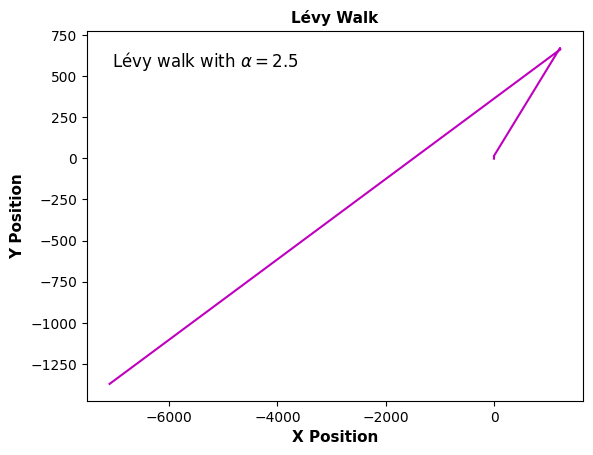

In [3]:
# Generate Lévy flight trajectory
x_measured, y_measured, _ = levy_flight_2D_2(n_redirections=10000, n_max=10000, lalpha=1.5, tmin=1, measuring_dt=1)
# Plot Lévy WALK trajectory
plt.plot(x_measured, y_measured, color='m')
plt.xlabel('X Position',fontsize=11, fontweight='bold')
plt.ylabel('Y Position',fontsize=11,fontweight='bold')
plt.title('Lévy Walk',fontsize=11,fontweight='bold')
# Prepare text with parameters using TeX markup
param_text = r"Lévy walk with $\alpha = 2.5$"
plt.text(0.05, 0.95, param_text, transform=plt.gca().transAxes, fontsize=12,verticalalignment='top')
plt.savefig("LeavyWalk.pdf")
plt.show()

In [4]:

# Load parameters, set up KDE, and define other simulation parameters
normed_loc_params, mean_params, std_params = load_parameters('intermittent_est_params.txt')
kde = setup_kde(normed_loc_params)

N = 1000000  # Number of points
N_iter = 2000  # Number of iterations
integration_factor = 1
g_tau = 1
tau_list = np.arange(1, 50)
re_estimations = 5  
opt_iter = 200      
redim_max = 2
# Perform iterations
#og_params, lev_params_int, adj_r_square_int_lev, adj_r_square_int_int, est_params, est_params2 = perform_iterations(
#    N_iter, N, integration_factor, g_tau, kde, std_params, mean_params, tau_list
#)

In [5]:
# Define the parameters for synthetic data
g_v0 = 5.0
g_D = 1.0
g_lambda_B = 0.05
lambda_B = 0.05
g_lambda_D = 0.005

factor1 = 1
factor2 = 1
factor3 = 1
factor4 = 1

# Compute synthetic data
tau_list = np.arange(1, 50)
x_loc,y_loc = intermittent2(N*integration_factor,g_tau/integration_factor,g_v0*factor1,g_D*factor2,g_lambda_B*factor3,g_lambda_D*factor4)
    
# Initialize the lists
x_list, y_list, dx_list, dy_list = [], [], [], []
dx4, dy4, dx2, dy2 = [], [], [], []

for i in tau_list:
    x_list.append(x_loc[::i * integration_factor])
    y_list.append(y_loc[::i * integration_factor])
    dx_list.append(np.diff(x_loc[::i * integration_factor]))
    dy_list.append(np.diff(y_loc[::i * integration_factor]))

    dx4.append(np.mean(np.array(dx_list[-1])**4))
    dy4.append(np.mean(np.array(dy_list[-1])**4))
    dx2.append(np.mean(np.array(dx_list[-1])**2))
    dy2.append(np.mean(np.array(dy_list[-1])**2))
# Convert to NumPy arrays and compute logarithms
dx4, dy4 = np.array(dx4), np.array(dy4)
dx4_log, dy4_log = np.log(dx4), np.log(dy4)
dx2, dy2 = np.array(dx2), np.array(dy2)
dx2_log, dy2_log = np.log(dx2), np.log(dy2)


In [6]:

# Initial guess for fitting parameters
initial_guess = [g_v0 * factor1, g_D * factor2, g_lambda_B * factor3, g_lambda_D * factor4]

# Perform fitting using dual annealing
result = dual_annealing(to_optimize_mom4, [(1e-6, 1e6)] * 4, x0=initial_guess)
popt_x = result.x
print("popt_x:", popt_x)
# Calculate the difference
difference = np.array(dx4) - 2 * np.array(dx2)

result_diff = dual_annealing(to_optimize_mom22_4_diff, [(1e-6, 1e3)] * 4, x0=initial_guess)
popt_x_diff = result_diff.x
x_intermittent, y_intermittent = intermittent2(nt=1000000, dt=1, mean_bal_sac=g_v0, diffusion=g_D, rate21=g_lambda_B, rate12=g_lambda_D)
x_levy, y_levy, _ = levy_flight_2D_2(n_redirections=1000000, n_max=1000000, lalpha=1.5, tmin=1, measuring_dt=1)
def calculate_moments(data, tau_list):
    dx2 = []
    dx4 = []
    for tau in tau_list:
        dx = np.diff(data[::tau])
        dx2.append(np.mean(dx**2))
        dx4.append(np.mean(dx**4))
    return np.array(dx2), np.array(dx4)
dx2_intermittent, dx4_intermittent = calculate_moments(x_intermittent, tau_list)
dx2_levy, dx4_levy = calculate_moments(x_levy, tau_list)

popt_x: [5.    1.    0.05  0.005]


In [7]:
# Simplify the bounds to very wide ranges
simple_bounds = (0, np.inf)
# Double-check initial guesses
initial_guess = [g_v0*factor1, g_D*factor2, g_lambda_B*factor3, g_lambda_D*factor4]
print("Initial Guesses:", initial_guess)

# If initial_guess is derived from popt_x, ensure popt_x is feasible
print("Previous Optimal Parameters (popt_x):", popt_x)
# Quick test of the model function with different parameter sets
test_params = [1, 1, 1, 1]  
try:
    test_output = mom22_4_diff(tau_list, *test_params)
    print("Model function output with test parameters:", test_output)
except Exception as e:
    print("Error in model function with test parameters:", e)
try:
    popt_x_diff, pcov_x = scipy.optimize.curve_fit(
        mom22_4_diff, 
        np.array(tau_list), 
        (np.array(dx4) - 2 * np.array(dx2)),
        p0=initial_guess, 
        bounds=simple_bounds,
        maxfev=5000000
    )
    print("Optimized Parameters:", popt_x_diff)
except ValueError as e:
    print("ValueError encountered:", e)
popt_x_diff, pcov_x = scipy.optimize.curve_fit(mom22_4_diff, np.array(tau_list), (np.array(dx4) - 2*np.array(dx2)),p0 = popt_x ,bounds=(0.0001, [np.inf, np.inf, np.inf,np.inf]),maxfev=500000)
popt_x_diff2, pcov_x = scipy.optimize.curve_fit(mom22_4_diff, np.array(tau_list), (np.array(dx4) - 2*np.array(dx2)),p0 = [g_v0*factor1,g_D*factor2,g_lambda_B*factor3,g_lambda_D*factor4] ,bounds=(0.0001, [np.inf, np.inf, np.inf,np.inf]),maxfev=500000)
popt_x_diff2
import numpy as np
from scipy.optimize import curve_fit

Initial Guesses: [5.0, 1.0, 0.05, 0.005]
Previous Optimal Parameters (popt_x): [5.    1.    0.05  0.005]
Model function output with test parameters: [2.73069091e+00 1.53484771e+01 3.98449608e+01 7.73550777e+01
 1.28275073e+02 1.92708059e+02 2.70667177e+02 3.62145296e+02
 4.67134410e+02 5.85629245e+02 7.17626875e+02 8.63125814e+02
 1.02212535e+03 1.19462515e+03 1.38062506e+03 1.58012503e+03
 1.79312501e+03 2.01962500e+03 2.25962500e+03 2.51312500e+03
 2.78012500e+03 3.06062500e+03 3.35462500e+03 3.66212500e+03
 3.98312500e+03 4.31762500e+03 4.66562500e+03 5.02712500e+03
 5.40212500e+03 5.79062500e+03 6.19262500e+03 6.60812500e+03
 7.03712500e+03 7.47962500e+03 7.93562500e+03 8.40512500e+03
 8.88812500e+03 9.38462500e+03 9.89462500e+03 1.04181250e+04
 1.09551250e+04 1.15056250e+04 1.20696250e+04 1.26471250e+04
 1.32381250e+04 1.38426250e+04 1.44606250e+04 1.50921250e+04
 1.57371250e+04]
Optimized Parameters: [8.01532425e+00 3.38107873e+00 4.64831952e-02 6.52435088e-04]


In [8]:
# Fit the second moment
popt_dx2_intermittent, _ = curve_fit(mom2_model, tau_list, dx2_intermittent)
popt_dx2_levy, _ = curve_fit(mom2_model, tau_list, dx2_levy)

# Fit the fourth moment
popt_dx4_intermittent, _ = curve_fit(mom4_model, tau_list, dx4_intermittent)
popt_dx4_levy, _ = curve_fit(mom4_model, tau_list, dx4_levy)


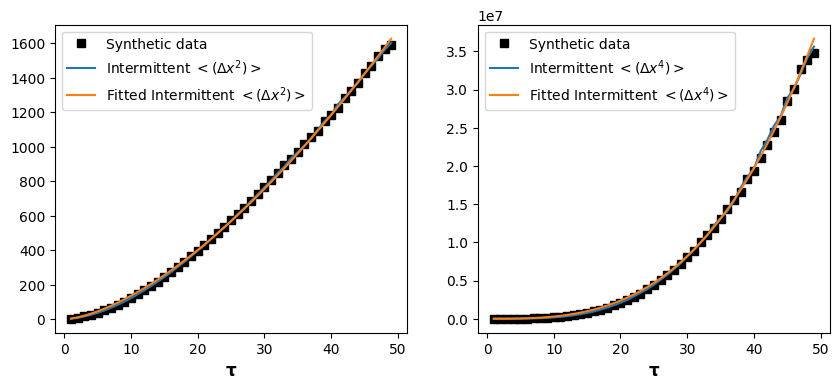

In [9]:
plt.figure(figsize=(10, 4))
# Plot for the second moment
plt.subplot(1, 2, 1)
plt.plot((tau_list), dx2, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, dx2_intermittent, label='Intermittent $<(Δx^2)>$')  # Corrected label
plt.plot(tau_list, mom2_model(tau_list, *popt_dx2_intermittent), label='Fitted Intermittent $<(Δx^2)>$')
#plt.plot(tau_list, dx2_levy, label='Lévy $<(Δx^2)>$')
#plt.plot(tau_list, mom2_model(tau_list, *popt_dx2_levy), label='Fitted Lévy $<(Δx^2)>$')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12)  
plt.legend()

# Plot for the fourth moment
plt.subplot(1, 2, 2)
# Plot the synthetic data
plt.plot((tau_list), dx4, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, dx4_intermittent, label='Intermittent $<(Δx^4)>$')
plt.plot(tau_list, mom4_model(tau_list, *popt_dx4_intermittent), label='Fitted Intermittent $<(Δx^4)>$')
#plt.plot(tau_list, dx4_levy, label='Lévy $<(Δx^4)>$')
#plt.plot(tau_list, mom4_model(tau_list, *popt_dx4_levy), label='Fitted Lévy $<(Δx^4)>$')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12) 
plt.legend()

plt.show()


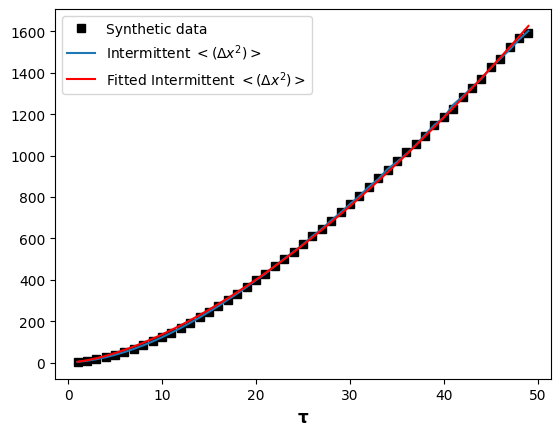

In [10]:
plt.plot((tau_list), dx2, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, dx2_intermittent, label='Intermittent $<(Δx^2)>$')
plt.plot(tau_list, mom2_model(tau_list, *popt_dx2_intermittent),color = "red", label='Fitted Intermittent $<(Δx^2)>$')
#plt.plot(tau_list, dx2_levy, label='Lévy $<(Δx^2)>$')
#plt.plot(tau_list, mom2_model(tau_list, *popt_dx2_levy), label='Fitted Lévy $<(Δx^2)>$')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12) 
plt.legend()
plt.savefig("int_d_x2.pdf")
plt.show()


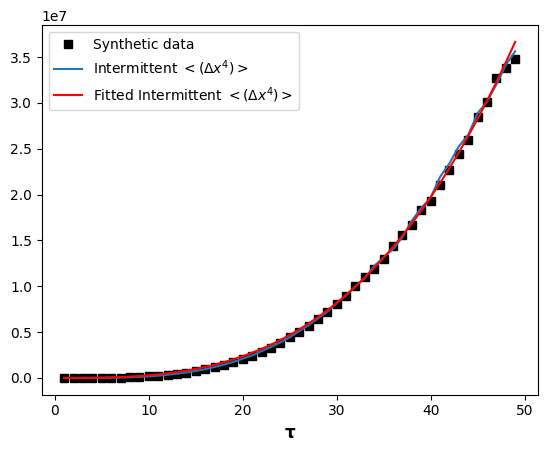

In [11]:
# Plot the synthetic data
plt.plot((tau_list), dx4, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, dx4_intermittent, label='Intermittent $<(Δx^4)>$')
plt.plot(tau_list, mom4_model(tau_list, *popt_dx4_intermittent),color = "red", label='Fitted Intermittent $<(Δx^4)>$')
#plt.plot(tau_list, dx4_levy, label='Lévy $<(Δx^4)>$')
#plt.plot(tau_list, mom4_model(tau_list, *popt_dx4_levy), label='Fitted Lévy $<(Δx^4)>$')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12) 
plt.legend()
plt.savefig("int_d_x4.pdf")
plt.show()

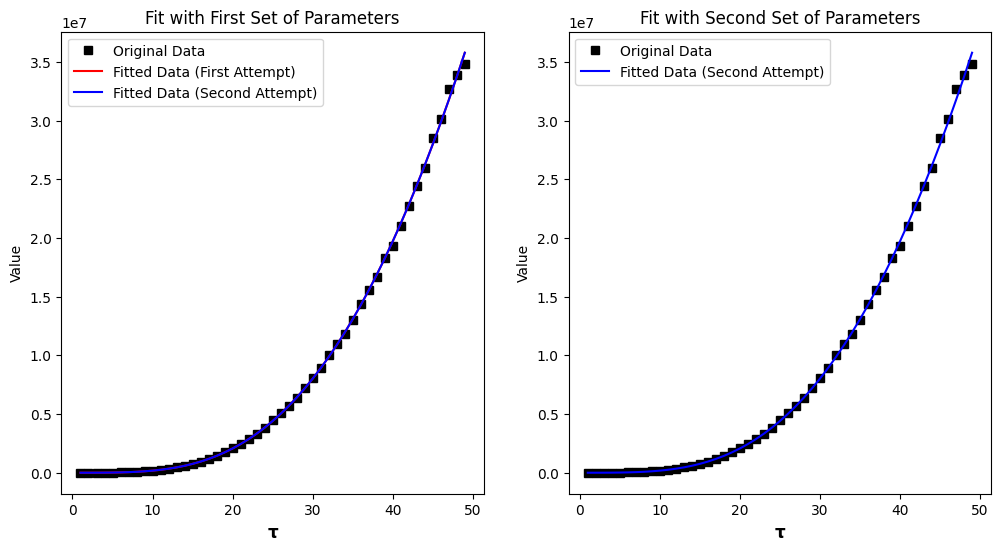

In [12]:
# Original Data
original_data = dx4

# Fitted Data Using First Set of Optimized Parameters
fitted_data1 = mom22_4_diff(np.array(tau_list), *popt_x_diff)

# Fitted Data Using Second Set of Optimized Parameters
fitted_data2 = mom22_4_diff(np.array(tau_list), *popt_x_diff2)

# Plotting
plt.figure(figsize=(12, 6))

# Plot with first set of parameters
plt.subplot(1, 2, 1)
plt.plot(tau_list, original_data, 'ks', label='Original Data')
plt.plot(tau_list, fitted_data1, label='Fitted Data (First Attempt)', color='red')
plt.plot(tau_list, fitted_data2, label='Fitted Data (Second Attempt)', color='blue')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12)
plt.ylabel('Value')
plt.title('Fit with First Set of Parameters')
plt.legend()

# Plot with second set of parameters
plt.subplot(1, 2, 2)
plt.plot(tau_list, original_data, 'ks', label='Original Data')
plt.plot(tau_list, fitted_data2, label='Fitted Data (Second Attempt)', color='blue')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12)
plt.ylabel('Value')
plt.title('Fit with Second Set of Parameters')
plt.legend()

plt.show()


## Levy

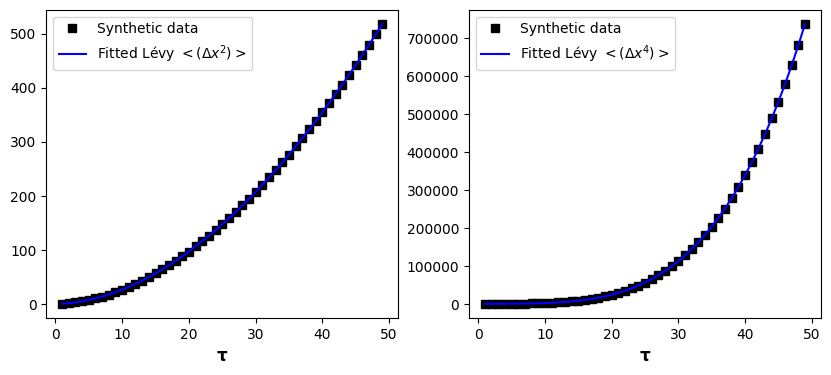

In [13]:
import numpy as np
o_t_mins = 0.007
l_alpha = 2
tau_list = np.arange(1, 50)
#for factor1 in np.arange(0,1,1.0/325):#uremove this part
#    l_alpha = o_alpha + factor1
#    for factor2 in np.arange(0,0.008,1):
#        g_t_mins = 1.5*o_t_mins - 0.5*factor1*o_t_mins
#        print(factor1,factor2)

# Function to calculate moments
'''def calculate_moments(data, tau_list):
    dx2 = []
    dx4 = []
    for tau in tau_list:
        dx = np.diff(data[::tau])
        dx2.append(np.mean(dx**2))
        dx4.append(np.mean(dx**4))
    return np.array(dx2), np.array(dx4)'''

# Main loop for parameter sweep
for factor1 in np.arange(0, 1, 1.0 / 1):
    for factor2 in np.arange(0, 0.008, 1):
        g_t_mins = 1.5 * o_t_mins - 0.5 * factor1 * o_t_mins

        # Reset dy_lev and dx_lev for each parameter set
        dy_lev = []
        dx_lev = []

        for i in range(10):
            # Generate synthetic data
            lx_lev, ly_lev, lt_lev = levy_flight_2D_2(int(15000000 * l_alpha * 0.01 / g_t_mins), 150000, l_alpha, g_t_mins, 1)
            dy_lev.append(np.diff(ly_lev))
            dx_lev.append(np.diff(lx_lev))

        # Aggregate the data
        y_lev = np.cumsum(np.hstack(dy_lev))
        x_lev = np.cumsum(np.hstack(dx_lev))

        # Calculate momentsx
        dx2, dx4 = calculate_moments(x_lev,tau_list)

        # Fit the moments
        popt_dx2, _ = curve_fit(mom2_model, tau_list, dx2)
        popt_dx4, _ = curve_fit(mom4_model, tau_list, dx4)

        # Plotting
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)  # Plot for the second moment
        plt.plot(tau_list, dx2, 'ks', alpha=1, label='Synthetic data')
        plt.plot(tau_list, mom2_model(tau_list, *popt_dx2), label='Fitted Lévy $<(Δx^2)>$',color ='blue')
        plt.xlabel(r'$\mathbf{\tau}$', fontsize=12, fontweight = 'bold')
        plt.legend()
        #plt.savefig("bestlevy_fit_2.pdf")

        plt.subplot(1, 2, 2)  # Plot for the fourth moment
        plt.plot(tau_list, dx4, 'ks', alpha=1, label='Synthetic data')
        plt.plot(tau_list, mom4_model(tau_list, *popt_dx4), label='Fitted Lévy $<(Δx^4)>$',color ='blue')
        plt.xlabel(r'$\mathbf{\tau}$', fontsize=12,fontweight = 'bold')
        plt.legend()
        #plt.savefig("bestlevy_fit_4.pdf")
        plt.show()

In [14]:
#plt.plot(lx_lev, ly_lev)

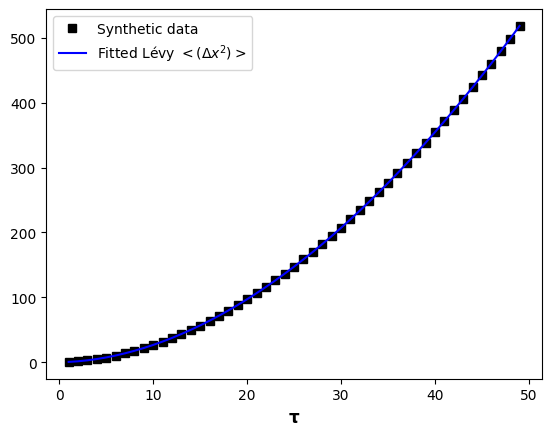

In [15]:
plt.plot(tau_list, dx2, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, mom2_model(tau_list, *popt_dx2), label='Fitted Lévy $<(Δx^2)>$',color ='blue')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12, fontweight = 'bold')
plt.legend()
plt.show()


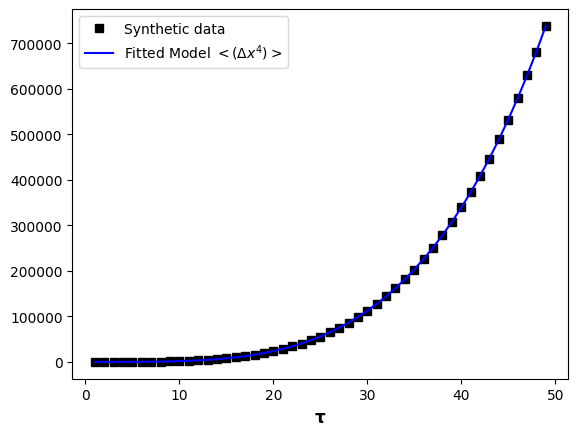

In [16]:
plt.plot(tau_list, dx4, 'ks', alpha=1, label='Synthetic data')
plt.plot(tau_list, mom4_model(tau_list, *popt_dx4), label='Fitted Model $<(Δx^4)>$',color ='blue')
plt.xlabel(r'$\mathbf{\tau}$', fontsize=12,fontweight = 'bold')
plt.legend()
#plt.savefig("bestlevy_fit_4.pdf")
plt.show()